# NOTE: This model was trained for approximately 3 hours and 5 minutes with Google Colab's TPU, and no other resources were available to increase the accuracy of the model.

In [ ]:
!pip install tensorflow gdown matplotlib

In [ ]:
import os
import zipfile
import gdown
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

No GPU found


In [ ]:
# Enable dynamic memory allocation for the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download and extract the dataset
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba-dataset.zip"

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

if not os.path.exists("img_align_celeba"):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("img_align_celeba")

In [ ]:
# Preprocess the dataset
def preprocess(image):
    image = tf.image.resize(image, (64, 64))  # Resize images to 64x64
    image = (image - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return image

In [ ]:
# Load and prepare the dataset
def load_dataset(data_dir):
    image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = preprocess(image)
        return image

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

data_dir = "img_align_celeba/img_align_celeba"
batch_size = 64
buffer_size = 60000

train_dataset = load_dataset(data_dir).shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Define the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8, 8, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
# Define the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# Create the generator and discriminator models
generator = build_generator()
discriminator = build_discriminator()

In [ ]:
# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
# Define the loss functions
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [ ]:
# Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# Define the training function
def train(dataset, epochs, save_dir):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Save the generator model at the end of each epoch
        generator.save(os.path.join(save_dir, f'generator_epoch_{epoch+1}.h5'))

        # Generate and save images to visualize progress
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        plt.imshow((generated_image[0, :, :, :] + 1) / 2)
        plt.axis('off')
        plt.savefig(os.path.join(save_dir, f'generated_image_epoch_{epoch+1}.png'))
        plt.show()
        plt.close()

        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

    # Save the final generator model
    final_model_path = os.path.join(save_dir, 'final_generator.h5')
    generator.save(final_model_path)
    return final_model_path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


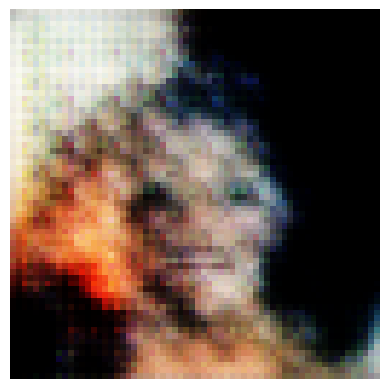

Epoch 1, Generator Loss: 1.3212394714355469, Discriminator Loss: 1.2468822002410889


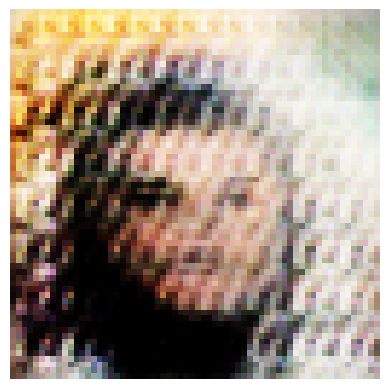

Epoch 2, Generator Loss: 1.7369601726531982, Discriminator Loss: 0.6204565763473511


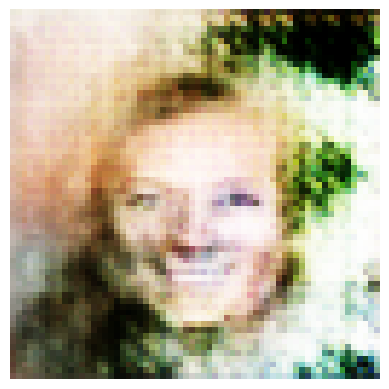

Epoch 3, Generator Loss: 1.8222007751464844, Discriminator Loss: 0.8883816003799438


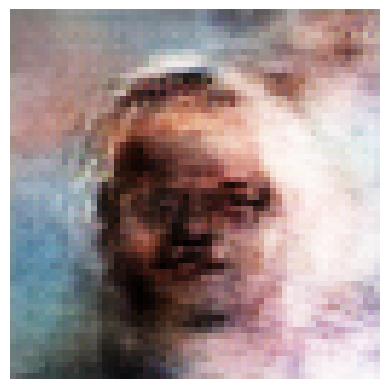

Epoch 4, Generator Loss: 1.4219049215316772, Discriminator Loss: 0.9090899229049683


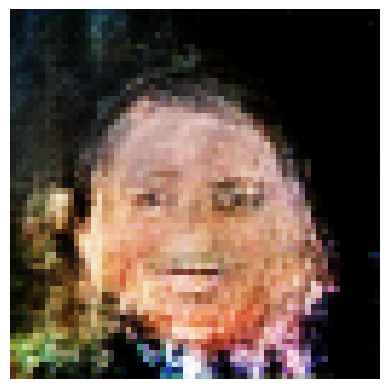

Epoch 5, Generator Loss: 1.6549690961837769, Discriminator Loss: 0.7576577663421631


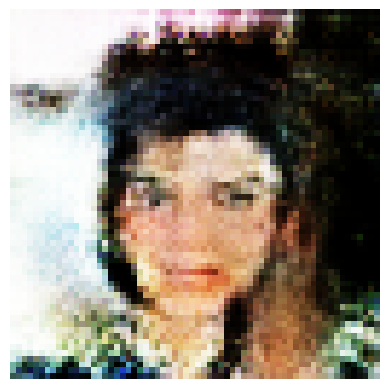

Epoch 6, Generator Loss: 2.084808349609375, Discriminator Loss: 0.737553596496582


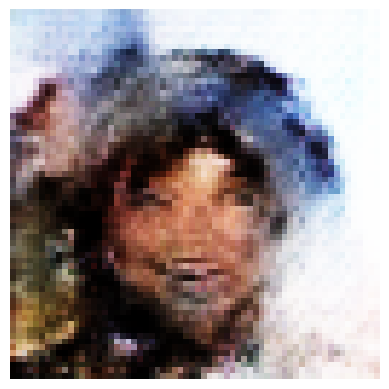

Epoch 7, Generator Loss: 2.011475086212158, Discriminator Loss: 0.6817580461502075


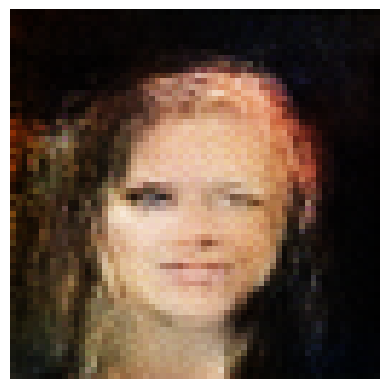

Epoch 8, Generator Loss: 1.8182483911514282, Discriminator Loss: 0.722232460975647


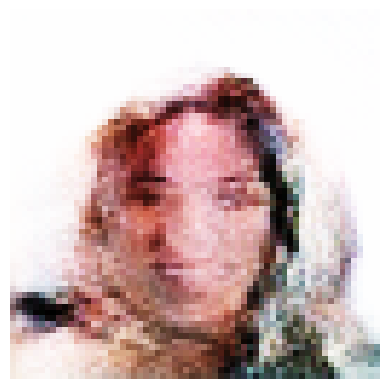

Epoch 9, Generator Loss: 1.982743501663208, Discriminator Loss: 0.7361018657684326


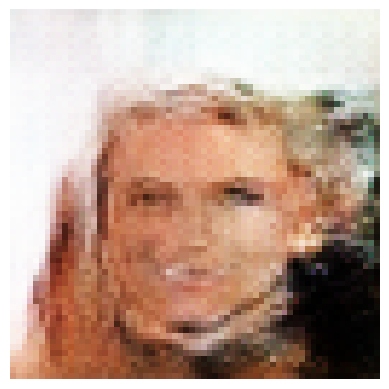

Epoch 10, Generator Loss: 1.6582509279251099, Discriminator Loss: 0.6246533393859863


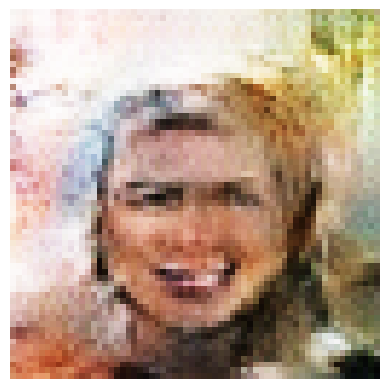

Epoch 11, Generator Loss: 2.064890146255493, Discriminator Loss: 0.6384584307670593


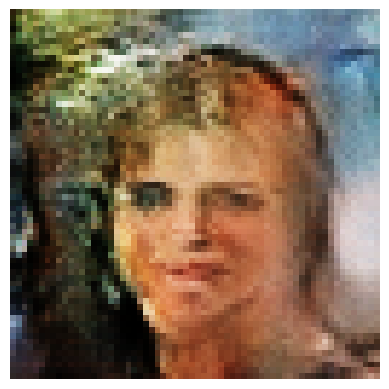

Epoch 12, Generator Loss: 2.250856399536133, Discriminator Loss: 1.039342999458313


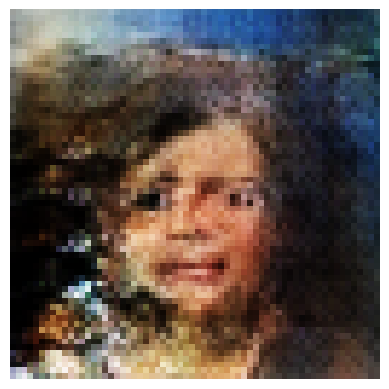

Epoch 13, Generator Loss: 1.715533971786499, Discriminator Loss: 0.7783139944076538


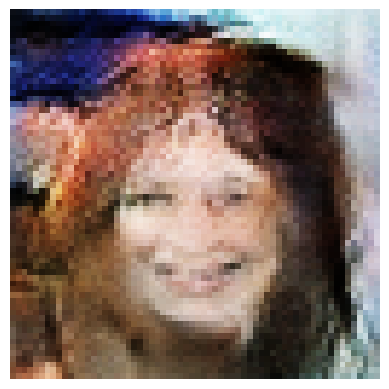

Epoch 14, Generator Loss: 2.1747066974639893, Discriminator Loss: 0.6902872920036316


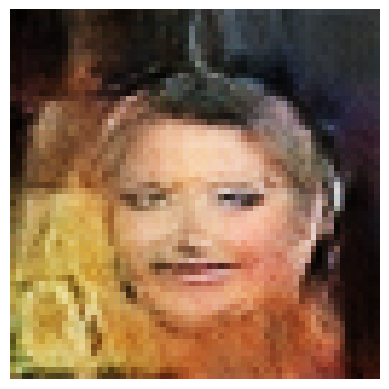

Epoch 15, Generator Loss: 1.8098149299621582, Discriminator Loss: 1.2830727100372314


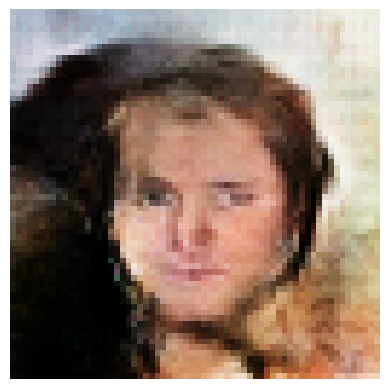

Epoch 16, Generator Loss: 1.9160735607147217, Discriminator Loss: 0.7484736442565918


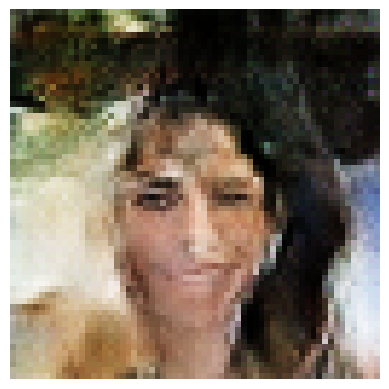

Epoch 17, Generator Loss: 2.3140649795532227, Discriminator Loss: 0.4252377152442932


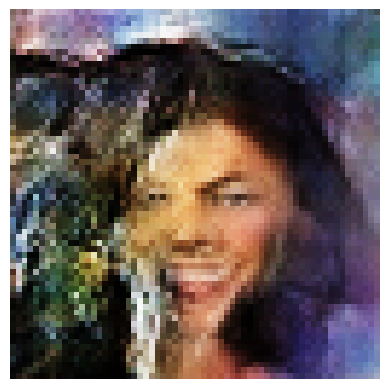

Epoch 18, Generator Loss: 2.511211395263672, Discriminator Loss: 1.4716320037841797


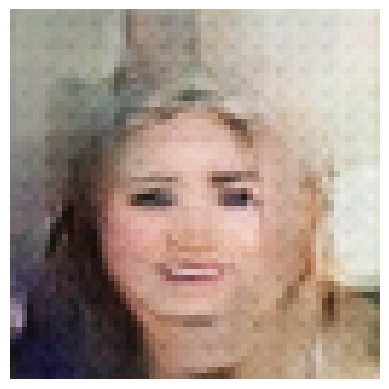

Epoch 19, Generator Loss: 2.6409645080566406, Discriminator Loss: 0.3467176556587219


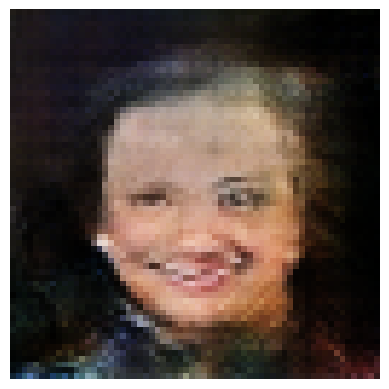

Epoch 20, Generator Loss: 2.64981746673584, Discriminator Loss: 0.41423743963241577


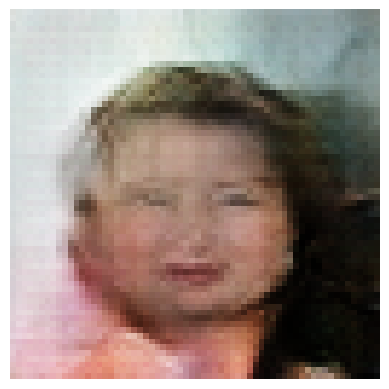

Epoch 21, Generator Loss: 1.9978256225585938, Discriminator Loss: 0.5717673301696777


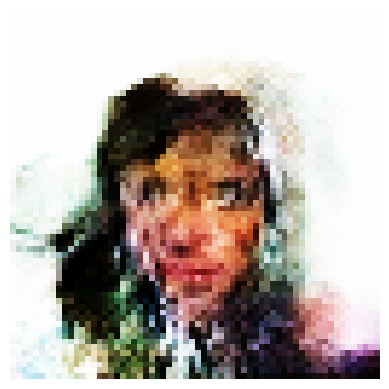

Epoch 22, Generator Loss: 2.2618556022644043, Discriminator Loss: 0.6553635597229004


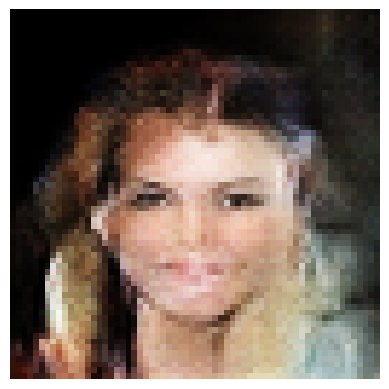

Epoch 23, Generator Loss: 1.5269405841827393, Discriminator Loss: 1.0222504138946533


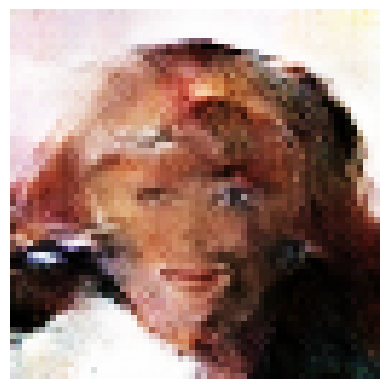

Epoch 24, Generator Loss: 1.843651294708252, Discriminator Loss: 1.1425445079803467


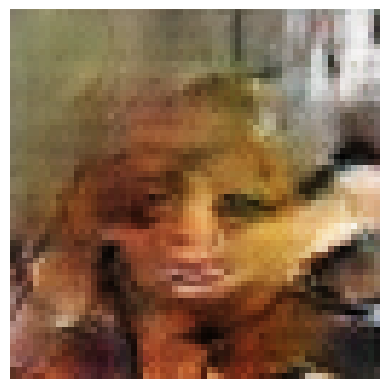

Epoch 25, Generator Loss: 1.8109850883483887, Discriminator Loss: 0.6733136177062988


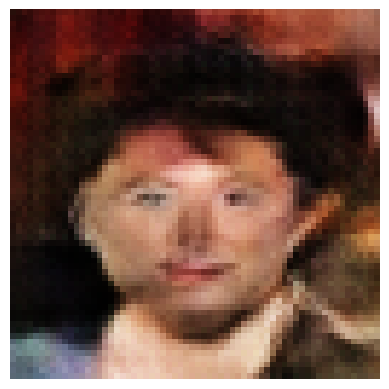

Epoch 26, Generator Loss: 2.5910916328430176, Discriminator Loss: 1.06219482421875


In [ ]:
# Set parameters and train the GAN
epochs = 26
save_dir = '/content/drive/MyDrive/gan_training'
os.makedirs(save_dir, exist_ok=True)

final_model_path = train(train_dataset, epochs, save_dir)
print("Final generator model saved to Google Drive.")

In [ ]:
# Display the result of the final trained generator
for i in range(2):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    plt.imshow((generated_image[0, :, :, :] + 1) / 2)
    plt.axis('off')
    plt.show()

# Test the generator model

Mounted at /content/drive


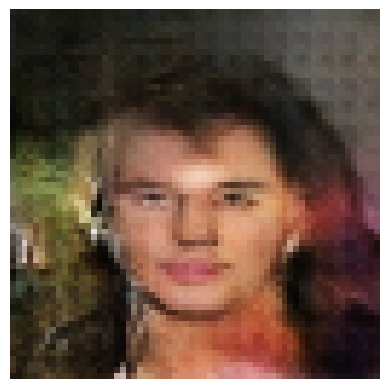

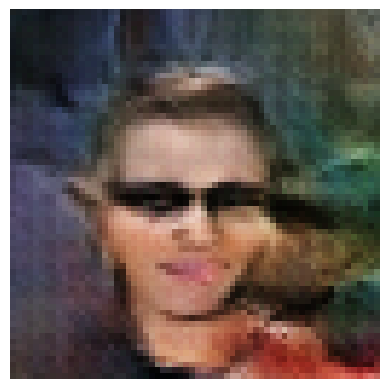

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# import driver
from google.colab import drive
drive.mount('/content/drive')

# Load the generator model from an .h5 file
generator = load_model('/content/drive/MyDrive/gan_training/final_generator.h5')

# Directory to save generated images
save_dir = '/content/drive/MyDrive/gan_training/generated_images'
os.makedirs(save_dir, exist_ok=True)

# Function to display and save generated images
def display_generated_image(generated_image, test_number, save_dir):
    # Ensure generated_image is in the range [0, 1]
    generated_image = (generated_image + 1) / 2

    # Plot the image
    plt.imshow(generated_image[0])  # Display the first image in the batch
    plt.axis('off')

    # Save and show the image
    plt.savefig(os.path.join(save_dir, f'generated_image_{test_number+1}.png'))
    plt.show()
    plt.close()

# Generate and display images using the loaded generator model
for i in range(2):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    display_generated_image(generated_image, i, save_dir)
